# 03 - Modelo con preprocesado y SVM  
**Competencia AI4ENG UDEA – 2025-2**  
En este notebook se entrena un modelo **SVM** para predecir la variable objetivo **RENDIMIENTO_GLOBAL**, utilizando preprocesamiento básico, codificación, escalado y reducción de dimensionalidad con PCA.


Importación de librerías

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import os


Carga de datos

In [4]:
train_path = "/content/sample_data/train.csv"
test_path = "/content/sample_data/test.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (692500, 21)
Test shape: (296786, 20)


Identificación de la variable objetivo

In [5]:
target = "RENDIMIENTO_GLOBAL"
y = train[target]
X = train.drop(columns=[target])

Unificación temporal para preprocesado consistente

In [6]:
X["is_train"] = 1
test["is_train"] = 0

full = pd.concat([X, test], ignore_index=True)
full.shape


(989286, 21)

Limpieza básica

In [7]:
# Ejemplo: rellenar nulos simples
full = full.fillna({
    col: full[col].median() if full[col].dtype != 'object' else full[col].mode()[0]
    for col in full.columns
})


Identificación de variables numéricas y categóricas

In [8]:
num_cols = full.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = full.select_dtypes(include=['object']).columns.tolist()

num_cols = [c for c in num_cols if c not in ["is_train"]]


Pipeline de preprocesamiento

In [9]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


Aplicar transformaciones

In [10]:
full_processed = preprocess.fit_transform(full)

full_processed.shape


(989286, 1053)

Separar nuevamente train y test

In [11]:
train_processed = full_processed[full["is_train"].values == 1]
test_processed = full_processed[full["is_train"].values == 0]

Separar X_train, X_valid, y_train, y_valid

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_processed,
    y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape


((554000, 1053), (138500, 1053), (554000,), (138500,))

Guardar datasets preprocesados

In [13]:
os.makedirs("processed", exist_ok=True)

np.save("processed/X_train.npy", X_train)
np.save("processed/X_valid.npy", X_valid)
np.save("processed/y_train.npy", y_train)
np.save("processed/y_valid.npy", y_valid)
np.save("processed/test_processed.npy", test_processed)

print("Archivos guardados en carpeta 'processed/'")


Archivos guardados en carpeta 'processed/'


ENTRENAMIENTO MODELO RÁPIDO TIPO SVM (SGDClassifier)

⚡ Entrenando modelo tipo SVM (SGDClassifier: rápido y eficiente)...
✅ Entrenamiento completado.

🎯 Accuracy en validación: 0.3965

              precision    recall  f1-score   support

        alto       0.54      0.58      0.56     35165
        bajo       0.49      0.35      0.41     34573
  medio-alto       0.28      0.36      0.32     34259
  medio-bajo       0.31      0.29      0.30     34503

    accuracy                           0.40    138500
   macro avg       0.41      0.40      0.40    138500
weighted avg       0.41      0.40      0.40    138500



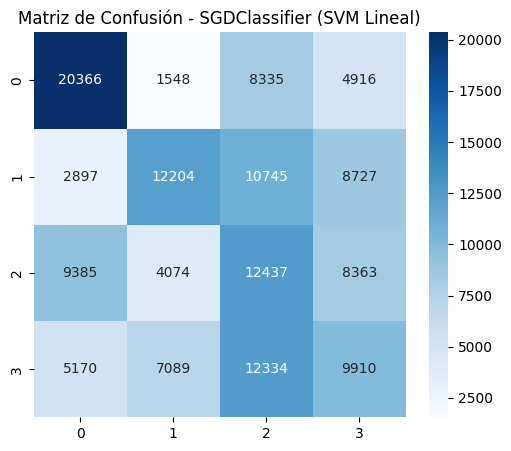


🔮 Generando predicciones para el archivo test...
Primeras predicciones: ['medio-alto' 'medio-bajo' 'alto' 'bajo' 'medio-alto' 'bajo' 'alto' 'alto'
 'medio-bajo' 'alto']
📁 Archivo de submission guardado como: submission_SGD_03.csv
💾 Modelo guardado como sgd_model_nb03.pkl


In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("⚡ Entrenando modelo tipo SVM (SGDClassifier: rápido y eficiente)...")

svm_model = SGDClassifier(
    loss="hinge",        # SVM lineal
    penalty="l2",
    max_iter=2000,
    tol=1e-3,
    class_weight="balanced",
    random_state=42
)

svm_model.fit(X_train, y_train)

print("✅ Entrenamiento completado.")


# ============================================================
# VALIDACIÓN DEL MODELO
# ============================================================

y_pred = svm_model.predict(X_valid)

acc = accuracy_score(y_valid, y_pred)
print(f"\n🎯 Accuracy en validación: {acc:.4f}\n")
print(classification_report(y_valid, y_pred))

# Matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_valid, y_pred),
            annot=True, cmap="Blues", fmt="d")
plt.title("Matriz de Confusión - SGDClassifier (SVM Lineal)")
plt.show()


# ============================================================
# PREDICCIÓN SOBRE TEST PROCESADO
# ============================================================

print("\n🔮 Generando predicciones para el archivo test...")
test_predictions = svm_model.predict(test_processed)

print("Primeras predicciones:", test_predictions[:10])


# ============================================================
# CREACIÓN DEL ARCHIVO SUBMISSION
# ============================================================

# Cargar el archivo submission_example
submission_example_path = "/content/sample_data/submission_example.csv"
submission = pd.read_csv(submission_example_path)

# Reemplazar la columna de predicción (toma la última columna del archivo)
prediction_column = submission.columns[-1]
submission[prediction_column] = test_predictions

# Guardar archivo final
submission_path = "submission_SGD_03.csv"
submission.to_csv(submission_path, index=False)

print(f"📁 Archivo de submission guardado como: {submission_path}")


# ============================================================
# GUARDAR MODELO (POR SI SE NECESITA EN EL NOTEBOOK 99)
# ============================================================

import joblib

joblib.dump(svm_model, "sgd_model_nb03.pkl")
print("💾 Modelo guardado como sgd_model_nb03.pkl")
